# <center> CNN-LSTM
 Final Project </center>
<center> Spring 2024</center>

## Objective of the Project

Machine learning is a rapidly evolving field.  Thus, part of the requirement of being a successful machine learning data scientist is to keep up with the state of the art machine learning techniques in the research literature.  Part of the goal of this project is to prepare you for doing independent research.  In some parts of this project, you might be asked to read the material on a topic that you are not totally familiar and apply the techniques that you learned from the reading.

## Introduction

In this project we are interested in building models similar to the ones shown in [CLEVR: A Diagnostic Dataset for Compositional Language and Elementary Visual Reasoning](https://arxiv.org/pdf/1612.06890.pdf) by Johnson et al (the first paper we read in Precept 10).  You should do all computations, including the part to test your code, on the Adroit cluster since the dataset is too large for a personal computer to handle.

<!-- In this project we are interested in building a model that predicts the types of animals and the number of animals shown on images in the `Wild` dataset.  We will deviate from the approach used by [Parham et al.](https://ieeexplore.ieee.org/document/8354227) (the paper that we read in Precept 8) and employ a less complicated method inspired by the one used in [`Learn to Classify and Count: A Unified Framework for Object Classification and Counting`](https://dl.acm.org/doi/abs/10.1145/3191442.3191459) by Song and Qui instead. -->

In [ ]:
# Import libraries
import json
import os
import pickle
from PIL import Image
from IPython.display import display

# for data manipulations
import numpy as np
import math
import pandas as pd

# Natural language processing tools
import nltk
from nltk.corpus import stopwords
from nltk.stem.porter import *


import torch # for training neural network
import torch.nn as nn
import torch.nn.functional as F # for activation functions;
                                # max pooling functions (for NLP) etc.

#from collections import Counter
#from collections import defaultdict

import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset, RandomSampler, Subset, Dataset
from torchvision import datasets, transforms, utils

import matplotlib.pyplot as plt # for plotting

import random
import datetime
from tqdm import tqdm # tqdm shows the progress bar, number of iterations,
                      # time taken to run the loop, and frequency of iterations per second
from collections import defaultdict

import utils # make sure to place utils.py in the directory as this file

In [ ]:
from torch.nn import LayerNorm

## Question 1 Getting Familiar with the Data

### Part a. File directory structure

The function `os.listdir(path)` returns a list containing the names of the entries in the specified directory `path`.  For example, the code cell below shows that there are three files in the folder `questions`.  The first file is called `CLEVR_test_questions.json`.

In [ ]:
# replace <user_name> with your user name
# similarly, replace all the directories mentioned in this file with
# the appropriate directories
clevr_dir = '/scratch/network/mz8189/SML301_S24/data/CLEVR_v1.0'

In [ ]:
quest_path = '/scratch/network/mz8189/SML301_S24/data/CLEVR_v1.0/questions'
file_names = os.listdir(quest_path)

print(type(file_names))
print(file_names[0])
print(file_names)
len(file_names)

<class 'list'>
CLEVR_test_questions.json
['CLEVR_test_questions.json', 'CLEVR_val_questions.json', 'CLEVR_train_questions.json', 'CLEVR_built_dictionaries.pkl']


4

In [ ]:
img_path = '/scratch/network/mz8189/SML301_S24/data/CLEVR_v1.0/images/train'
file_names = os.listdir(img_path)

print(type(file_names))
print(file_names[0:3])
#print(file_names)
len(file_names)

<class 'list'>
['CLEVR_train_043890.png', 'CLEVR_train_017333.png', 'CLEVR_train_017788.png']


70000

We can randomly select some of the images to inspect:

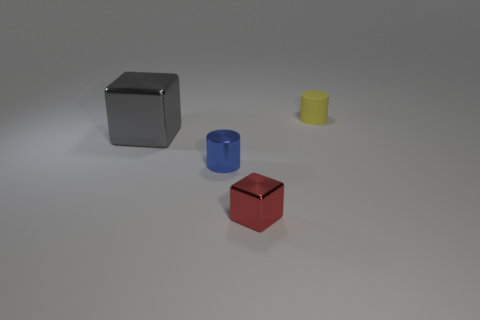

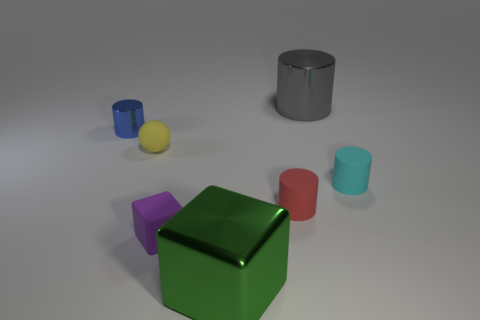

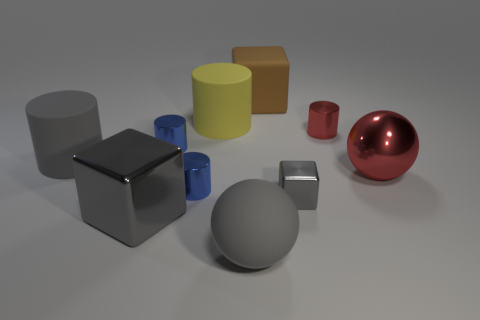

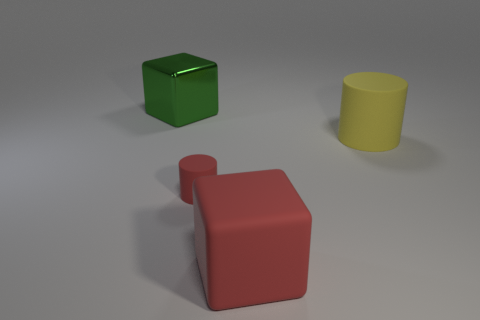

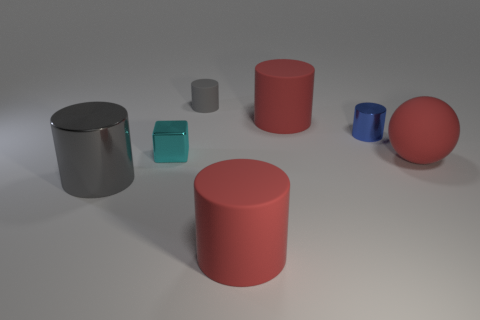

In [ ]:
# Randomly choose 5 of the images to print
random_numbers = [random.randint(0, 69999) for _ in range(5)]

for i in random_numbers:
    tmp = os.listdir(img_path)[i]
    img_pth = os.path.join(img_path, tmp)
    img = Image.open(img_pth)
    display(img)

To understand how the data is organized, please list the files stored under each of these folders:

* images
    + train
        - (Fill in blanks) ____70000 .png____(in what format? i.e., .pdf, .img, .jpeg, etc.) images
    + val
        - (Fill in blanks) ____15000 .png____(in what format?) images
    + test
        - (Fill in blanks) ____15000 .png____(in what format?) images
* questions  
    + CLEVR_train_questions.json  
    + CLEVR_val_questions.json (149991 questions)
    + CLEVR_test_questions.json (149988 questions)
* scenes
    + CLEVR_val_scenes.json  
    + CLEVR_train_scenes.json  


In [ ]:
#scenes
scene_path = '/scratch/network/mz8189/SML301_S24/data/CLEVR_v1.0/scenes'
scene_file_names = os.listdir(scene_path)

print(type(scene_file_names))
print(scene_file_names[0])
print(scene_file_names)
len(scene_file_names)

<class 'list'>
CLEVR_val_scenes.json
['CLEVR_val_scenes.json', 'CLEVR_train_scenes.json']


2

In [ ]:
#test images
train_img_path = '/scratch/network/mz8189/SML301_S24/data/CLEVR_v1.0/images/test'
train_file_names = os.listdir(train_img_path)

print(type(train_file_names))
print(train_file_names[0:3])
#print(train_file_names)
len(train_file_names)

<class 'list'>
['CLEVR_test_011743.png', 'CLEVR_test_004107.png', 'CLEVR_test_003360.png']


15000

In [ ]:
#test images
val_img_path = '/scratch/network/mz8189/SML301_S24/data/CLEVR_v1.0/images/val'
val_file_names = os.listdir(val_img_path)

print(type(val_file_names))
print(val_file_names[0:3])
#print(val_file_names)
len(val_file_names)

<class 'list'>
['CLEVR_val_008348.png', 'CLEVR_val_008869.png', 'CLEVR_val_006265.png']


15000

### Part b. `os.path.join()`

We will use the functions defined in the file `utils.py` for this project.  Many of those functions call the function `os.path.join()`, so we need to understand how this function works. The `os.path.join()` function is used to concatenate multiple text strings to make a path.  For example,


In [ ]:
json_val_filename = os.path.join(clevr_dir, 'questions', 'CLEVR_val_questions.json')
json_val_filename

'/scratch/network/mz8189/SML301_S24/data/CLEVR_v1.0/questions/CLEVR_val_questions.json'

With this path we can print the contents in the file *CLEVR_val_questions.json*.  Let's observe the outputs for the next few lines to understand the structure of our data.

In [ ]:
#load all words from all validation data
with open(json_val_filename, "r") as f:
    questions = json.load(f)['questions']

In [ ]:
print(type(questions))
len(questions)

<class 'list'>


149991

In [ ]:
questions[0:2]

[{'image_index': 0,
  'program': [{'inputs': [], 'function': 'scene', 'value_inputs': []},
   {'inputs': [0], 'function': 'filter_size', 'value_inputs': ['large']},
   {'inputs': [1], 'function': 'filter_material', 'value_inputs': ['metal']},
   {'inputs': [2], 'function': 'unique', 'value_inputs': []},
   {'inputs': [3], 'function': 'same_shape', 'value_inputs': []},
   {'inputs': [4], 'function': 'exist', 'value_inputs': []}],
  'question_index': 0,
  'image_filename': 'CLEVR_val_000000.png',
  'question_family_index': 39,
  'split': 'val',
  'answer': 'no',
  'question': 'Are there any other things that are the same shape as the big metallic object?'},
 {'image_index': 0,
  'program': [{'inputs': [], 'function': 'scene', 'value_inputs': []},
   {'inputs': [0], 'function': 'filter_color', 'value_inputs': ['green']},
   {'inputs': [1], 'function': 'unique', 'value_inputs': []},
   {'inputs': [2], 'function': 'same_shape', 'value_inputs': []},
   {'inputs': [3], 'function': 'filter_siz

In [ ]:
type(questions[0])

dict

In [ ]:
questions[0].keys()

dict_keys(['image_index', 'program', 'question_index', 'image_filename', 'question_family_index', 'split', 'answer', 'question'])

How many questions are in CLEVR_val_questions.json and in CLEVR_test_questions.json?  Add these numbers in paraphrases after the file names in Part a.

We have added the numbers in parentheses after the file names in part a.

In [ ]:
json_test_filename = os.path.join(clevr_dir, 'questions', 'CLEVR_test_questions.json')
json_test_filename

'/scratch/network/mz8189/SML301_S24/data/CLEVR_v1.0/questions/CLEVR_test_questions.json'

In [ ]:
#load all words from all test data
with open(json_test_filename, "r") as f:
    test_questions = json.load(f)['questions']

In [ ]:
len(test_questions)

149988

### Part c. Create the training, validation, test questions

Since the questions in `CLEVR_test_questions.json` have no answers, we will use `CLEVR_val_questions.json` to generate the test set and `CLEVR_train_questions.json` to generate the training and validation sets.  

Run the following cell below to create the dictionary that stores **the categories that we will use for this project** (some will be dropped later).

In [ ]:
classes = {
            'number':['0','1','2','3','4','5','6','7','8','9','10'],
            'material':['rubber','metal'],
            'color':['cyan','blue','yellow','purple','red','green','gray','brown'],
            'shape':['sphere','cube','cylinder'],
            'size':['large','small'],
            'exist':['yes','no']
        }

Run the two cells below to define the functions.  

In [ ]:
class ClevrDataset(Dataset):
    def __init__(self, clevr_dir, train, dictionaries, questions, transform=None):
        """
        Args:
            clevr_dir (string): Root directory of CLEVR dataset
			train (bool): Tells if we are loading the train or the validation datasets
            index (int): size of dataset we want
            transform (callable, optional): Optional transform to be applied
                on a sample.
        """
        if train:
            quest_json_filename = os.path.join(clevr_dir, 'questions', 'CLEVR_train_questions.json')
            self.img_dir = os.path.join(clevr_dir, 'images', 'train')
        else:
            quest_json_filename = os.path.join(clevr_dir, 'questions', 'CLEVR_val_questions.json')
            self.img_dir = os.path.join(clevr_dir, 'images', 'val')

#         cached_questions = quest_json_filename.replace('.json', '.pkl')
# #         if os.path.exists(cached_questions):
# #             print('==> using cached questions: {}'.format(cached_questions))
# #             with open(cached_questions, 'rb') as f:
# #                 self.questions = pickle.load(f)
# #         else:
#         with open(quest_json_filename, 'r') as json_file:
#             start, end = index
#             self.questions = json.load(json_file)['questions'][start:end]
# #             with open(cached_questions, 'wb') as f:
# #                 pickle.dump(self.questions, f)
        self.questions = questions
        self.clevr_dir = clevr_dir
        self.transform = transform
        self.dictionaries = dictionaries # mapping from numbers to letters (converts words to numbers)

    def answer_weights(self):
        n = float(len(self.questions))
        answer_count = Counter(q['answer'].lower() for q in self.questions)
        weights = [n/answer_count[q['answer'].lower()] for q in self.questions]
        return weights

    def __len__(self):
        return len(self.questions)

    def __getitem__(self, idx):
        current_question = self.questions[idx] # get current question
        img_filename = os.path.join(self.img_dir, current_question['image_filename']) # get current image
        image = Image.open(img_filename).convert('RGB') # convert the image to RGB format

        # maps questions and answers to indices in corresponding dictionary
        question = utils.to_dictionary_indexes(self.dictionaries[0], current_question['question'])
        # convert the answers from 1 to n to 0 to n-1
        answer = utils.to_dictionary_indexes(self.dictionaries[1], current_question['answer']) - 1
        '''if self.dictionaries[2][answer[0]]=='color':
            image = Image.open(img_filename).convert('L')
            image = numpy.array(image)
            image = numpy.stack((image,)*3)
            image = numpy.transpose(image, (1,2,0))
            image = Image.fromarray(image.astype('uint8'), 'RGB')'''

        # output is dictionary with image object, tokenized question, tokenized answer
        sample = {'image': image, 'question': question, 'answer': answer}

        if self.transform:
            sample['image'] = self.transform(sample['image'])

        return sample

In [ ]:
def initialize_dataset(clevr_dir, dictionaries, quests, state_description=True):
    train_quest, val_quest, test_quest = quests
    if not state_description:
        # does a series of transformations to the image
        train_transforms = transforms.Compose([transforms.Resize((128, 128)),
                                           transforms.Pad(8),
                                           transforms.RandomCrop((128, 128)),
                                           transforms.RandomRotation(2.8),  # .05 rad
                                           transforms.ToTensor()])
        test_transforms = transforms.Compose([transforms.Resize((128, 128)),
                                          transforms.ToTensor()])

        clevr_dataset_train = ClevrDataset(clevr_dir, True, dictionaries, train_quest, train_transforms)
        clevr_dataset_val = ClevrDataset(clevr_dir, True, dictionaries, val_quest, train_transforms)
        clevr_dataset_test = ClevrDataset(clevr_dir, False, dictionaries, test_quest, test_transforms)

    else:
        clevr_dataset_train = ClevrDatasetStateDescription(clevr_dir, True, dictionaries)
        clevr_dataset_test = ClevrDatasetStateDescription(clevr_dir, False, dictionaries)

    return clevr_dataset_train, clevr_dataset_val, clevr_dataset_test

Run the following code.  It will build the dictionaries for the questions and answers from the CLEVR dataset by using `CLEVR_train_questions.json`.  Have a look at the data type and the length of `dictionaries`.  What does each element in ` dictionaries` represent?  What is the smallest index in ` dictionaries`?

**Answer:** Based on the clarification posted in Ed, we are assuming this question is asking about "the dictionary for the questions [dictionaries[0]], not the `dictionaries` variable itself."

The dictionary for the question is a dictionary of key-value pairs, where keys represent words, and values represent corresponding integers (indices). There is one unique word for a corresponding index. The smallest index in dictionaries is 1. More specifically, these are all the classes for the questions, and their corresponding indices, which begin at 1. **Note that because these indices begin at 1 due to the padding, we will need to adjust our sizes later to account for this.**

Separately, we can also look at the variable named dictionaries. We see from our code below that the data type of the variable named dictionaries is a tuple, and the length is 3. Each element in dictionaries represents a dict, one of which is explained above.

In [ ]:
# build dictionaries for clevr
dictionaries = utils.build_dictionaries(clevr_dir)

==> using cached dictionaries: /scratch/network/mz8189/SML301_S24/data/CLEVR_v1.0/questions/CLEVR_built_dictionaries.pkl


In [ ]:
#check structure of dictionaries
print(type(dictionaries))
print(len(dictionaries))
print(type(dictionaries[0]))
print(dictionaries[0])

<class 'tuple'>
3
<class 'dict'>
{'are': 1, 'there': 2, 'more': 3, 'big': 4, 'green': 5, 'things': 6, 'than': 7, 'large': 8, 'purple': 9, 'shiny': 10, 'cubes': 11, '?': 12, 'how': 13, 'many': 14, 'other': 15, 'of': 16, 'the': 17, 'same': 18, 'shape': 19, 'as': 20, 'tiny': 21, 'cyan': 22, 'matte': 23, 'object': 24, 'is': 25, 'color': 26, 'sphere': 27, 'cube': 28, 'what': 29, 'material': 30, 'that': 31, 'right': 32, 'brown': 33, 'cylinder': 34, 'and': 35, 'left': 36, 'gray': 37, 'on': 38, 'side': 39, 'small': 40, 'rubber': 41, 'behind': 42, 'thing': 43, 'to': 44, 'metallic': 45, 'size': 46, 'any': 47, 'have': 48, 'block': 49, 'blue': 50, 'yellow': 51, 'a': 52, ';': 53, 'it': 54, 'ball': 55, 'its': 56, 'in': 57, 'front': 58, 'does': 59, 'number': 60, 'red': 61, 'spheres': 62, 'made': 63, 'metal': 64, 'cylinders': 65, 'both': 66, 'balls': 67, 'or': 68, 'blocks': 69, 'objects': 70, 'visible': 71, 'another': 72, 'has': 73, 'greater': 74, 'fewer': 75, 'less': 76, 'either': 77, 'anything': 78,

In [ ]:
print(dictionaries[0].values())
smallest_index = min(dictionaries[0].values())
print("smallest index: ", smallest_index)

dict_values([1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82])
smallest index:  1


Run the code below.  In `get_questions()`, we exclude the questions with answers in the class: 'number':['5','6','7','8','9','10']' since they have a lot fewer observations than other classes.  For each answer category, `get_questions()` will select `class_examples` of samples if there are enough of them; otherwise, the function will just select all the samples in that answer category.  The function also prints out the number of samples in each answer category in the original dataset.

In [ ]:
json_val_filename = os.path.join(clevr_dir, 'questions', 'CLEVR_val_questions.json')

json_train_filename = os.path.join(clevr_dir, 'questions', 'CLEVR_train_questions.json')
json_train_filename

'/scratch/network/mz8189/SML301_S24/data/CLEVR_v1.0/questions/CLEVR_train_questions.json'

In [ ]:
with open(json_train_filename, 'r') as f:
    nontest_quests = json.load(f)['questions']

with open(json_val_filename, 'r') as f:
    test_quests = json.load(f)['questions']

In [ ]:
train_quests = nontest_quests[:500000]
val_quests = nontest_quests[500000:]

In [ ]:
def get_questions(class_examples, quests):
    # Grouping data by unique values of 'value' key
    grouped_data = defaultdict(list)
    for item in quests:
        grouped_data[item['answer']].append(item)

    # Manually selecting class_examples samples from each group
    sampled_data = []
    for value, group in grouped_data.items():
        if value not in ['5', '6', '7', '8', '9', '10']:
            print(value, len(group))
            if len(group) >= class_examples:
                sampled_data.extend(random.sample(group, class_examples))
            else:
                sampled_data.extend(group)

    # Shuffle the sampled data
    return sampled_data

In [ ]:
train_questions = get_questions(5000, train_quests)
print('train dataset length:', len(train_questions))

yes 99379
2 21350
no 102829
rubber 22615
large 22321
0 34679
sphere 15041
gray 5554
cube 15016
blue 5638
brown 5633
1 41329
yellow 5689
purple 5656
cylinder 14976
small 22516
green 5553
metal 22433
3 10927
4 5342
cyan 5514
red 5520
train dataset length: 110000


In [ ]:
len(val_quests)

199989

In [ ]:
len(nontest_quests)

699989

In [ ]:
val_questions = get_questions(2000, val_quests)
print('Val dataset length:', len(val_questions))

yes 39742
2 8505
metal 8920
no 40884
sphere 6046
cyan 2217
large 9021
1 16578
0 13979
4 2076
red 2277
gray 2232
rubber 8862
small 9071
3 4329
blue 2235
cube 5998
cylinder 6075
brown 2293
purple 2317
green 2225
yellow 2285
Val dataset length: 44000


In [ ]:
test_questions = get_questions(1500, test_quests)
print('Test dataset length:', len(test_questions))

no 31040
yes 29795
metal 6747
2 6300
purple 1701
rubber 6657
cyan 1715
0 10520
brown 1650
sphere 4404
1 12313
yellow 1697
3 3368
red 1604
cylinder 4407
cube 4462
large 6674
blue 1723
gray 1672
small 6839
green 1782
4 1598
Test dataset length: 33000


In [ ]:
train_questions[2]

{'image_index': 24798,
 'program': [{'inputs': [], 'function': 'scene', 'value_inputs': []},
  {'inputs': [0], 'function': 'filter_material', 'value_inputs': ['rubber']},
  {'inputs': [1], 'function': 'filter_shape', 'value_inputs': ['cylinder']},
  {'inputs': [2], 'function': 'unique', 'value_inputs': []},
  {'inputs': [3], 'function': 'same_color', 'value_inputs': []},
  {'inputs': [4], 'function': 'exist', 'value_inputs': []}],
 'question_index': 247971,
 'image_filename': 'CLEVR_train_024798.png',
 'question_family_index': 37,
 'split': 'train',
 'answer': 'yes',
 'question': 'Is there anything else of the same color as the rubber cylinder?'}

We will now ready to create the datasets for the model!

In [ ]:
img_path = os.path.join(clevr_dir, 'images', 'train')
#dictionaries = utils.build_dictionaries(clevr_dir)

quests = (train_questions, val_questions, test_questions)

print('Initializing CLEVR dataset...')
clevr_dataset_train, clevr_dataset_val, clevr_dataset_test  = \
initialize_dataset(clevr_dir, dictionaries, quests, False)
print('CLEVR dataset initialized!')

Initializing CLEVR dataset...
CLEVR dataset initialized!


In [ ]:
print(len(clevr_dataset_train))
print(len(clevr_dataset_val))
print(len(clevr_dataset_test))

110000
44000
33000


In [ ]:
type(clevr_dataset_train)

__main__.ClevrDataset

In [ ]:
# Dict for questions

dictionaries[0]

{'are': 1,
 'there': 2,
 'more': 3,
 'big': 4,
 'green': 5,
 'things': 6,
 'than': 7,
 'large': 8,
 'purple': 9,
 'shiny': 10,
 'cubes': 11,
 '?': 12,
 'how': 13,
 'many': 14,
 'other': 15,
 'of': 16,
 'the': 17,
 'same': 18,
 'shape': 19,
 'as': 20,
 'tiny': 21,
 'cyan': 22,
 'matte': 23,
 'object': 24,
 'is': 25,
 'color': 26,
 'sphere': 27,
 'cube': 28,
 'what': 29,
 'material': 30,
 'that': 31,
 'right': 32,
 'brown': 33,
 'cylinder': 34,
 'and': 35,
 'left': 36,
 'gray': 37,
 'on': 38,
 'side': 39,
 'small': 40,
 'rubber': 41,
 'behind': 42,
 'thing': 43,
 'to': 44,
 'metallic': 45,
 'size': 46,
 'any': 47,
 'have': 48,
 'block': 49,
 'blue': 50,
 'yellow': 51,
 'a': 52,
 ';': 53,
 'it': 54,
 'ball': 55,
 'its': 56,
 'in': 57,
 'front': 58,
 'does': 59,
 'number': 60,
 'red': 61,
 'spheres': 62,
 'made': 63,
 'metal': 64,
 'cylinders': 65,
 'both': 66,
 'balls': 67,
 'or': 68,
 'blocks': 69,
 'objects': 70,
 'visible': 71,
 'another': 72,
 'has': 73,
 'greater': 74,
 'fewer': 75,


In [ ]:
# dict for answers
dictionaries[1]

{'yes': 1,
 '2': 2,
 'no': 3,
 'rubber': 4,
 'large': 5,
 '0': 6,
 'sphere': 7,
 'gray': 8,
 'cube': 9,
 'blue': 10,
 'brown': 11,
 '1': 12,
 'yellow': 13,
 'purple': 14,
 'cylinder': 15,
 'small': 16,
 'green': 17,
 'metal': 18,
 '3': 19,
 '4': 20,
 'cyan': 21,
 '6': 22,
 'red': 23,
 '5': 24,
 '8': 25,
 '7': 26,
 '9': 27,
 '10': 28}

### Part d. Create data_loaders

The partial code below should help you create the data loaders for the model building.  Please set all batch sizes (i.e., training, validation, and test) to 32.  

In [ ]:
def collate_samples(batch):
    """
    Used by DatasetLoader to merge together multiple samples into one mini-batch.
    """
    batch_size = len(batch)

    images = [d['image'] for d in batch]
    answers = [d['answer'] for d in batch]
    questions = [d['question'] for d in batch]

    # questions are not fixed length: they must be padded to the maximum length
    # in this batch, in order to be inserted in a tensor
    max_len = max(map(len, questions))

    padded_questions = torch.LongTensor(batch_size, max_len).zero_()
    for i, q in enumerate(questions):
        padded_questions[i, :len(q)] = q

    collated_batch = dict(
        image=torch.stack(images),
        answer=torch.stack(answers),
        question=padded_questions
    )
    return collated_batch

In [ ]:
random_seed = 2023
# torch.backends.cudnn.enabled = True
# torch.manual_seed(random_seed)

train_bch_size = 32
val_bch_size = 32
test_bch_size = 32

train_loader = torch.utils.data.DataLoader(clevr_dataset_train, \
                                           batch_size=train_bch_size, \
                                           shuffle=True, num_workers=16, \
                                           collate_fn=collate_samples)
val_loader = torch.utils.data.DataLoader(clevr_dataset_val, \
                                         batch_size=val_bch_size, \
                                         shuffle=True, num_workers=16, \
                                         collate_fn=collate_samples)
test_loader = torch.utils.data.DataLoader(clevr_dataset_test, \
                                          batch_size=test_bch_size, \
                                          shuffle=True, collate_fn=collate_samples)


### Part e. Summarize the steps

To ensure that you understand what we have done so far, please summarize the sequence of steps you have taken to process the data. In particular, mention the function you used for each step and explain the purpose of each execution. Remember that you will be graded based on quality, not quantity, so please be concise

**Answer:** In part a, we review the file directory structure. We use the os.listdir(path) function to return a list of the names entries in our specified directory path. We also have an example where we set a path to the questions in our dataset, use the os.listdir(path) function to return the aforementioned list, and then inspect the type and contents of these file names. We also do the same for the training images. Next, we randomly choose 5 images from our dataset and display them, using the os.path.join(img_path, tmp) function to extract the image path and then use the Image.open function. The goal of all this is to understand how the data is organized, determining three main things: amount/type of train/validation/test images, determine the .json names and length of the question data, and the .json file names for the validation/training scenes from CLEVR.

In part b, we use functions as defined in the utils.py file for this project, which has several functions that call os.path.join(), which is used to concatenate multiple text strings to make a path. With our newly created path, we can print contents of certain .json files using this method. First, we use the open() function to load all words from all validation data and determine the type and length of the list of questions. We also inspect the first few elements and the type of the elements, as well as the keys of the elemnts. We also determine the number of validation and test questions in the .json files from CLEVR.

In part c, we create the training, validation and test question sets. Given that CLEVR_test_questions.json has no answers, we make it so we use CLEVR_val_questions.json to generate the test set and CLEVR_train_questions.json to generate training/validation sets. First, we create a dictionary to store the categories we will use for this project and define two functions. We define the ClevrDataset class with the __init__ function to initialize questions, CLEVR directory, transform, and dictionaries that convert words to numbers. The __init__ function uses os.path.join() to obtain these path names. There is also the answer_weights function that returns the weights of answers, __len__ function that returns the length of the questions, and the __getitem__ function that returns the sample of dictionary with image object, tokenized question, and tokenized answer.

We also definite the initialize_dataset function that initializes the CLEVR dataset for training, validation, and testing. Next, we build dictionaries for the questions and answers from the CLEVR dataset by using CLEVER_train_questions.json. We inspect the datatype and length of dictionaries to be a tuple of length 3, where each element represents word-index pairs, with the smallest index being 1.  We use the utils.build_dictionaries function to do this. We also define a get_questions function to select class_examples of samples if there is enough, otherwise selecting all of them. It also prints the number of samples in each answer category in the original dataset. Now we are ready to create datasets for our model by using the os.path.join and initialize_dataset functions.

In part d, we create data loaders to build the models, setting batch sizes to 32. Here, we define and use a collate_samples function to merge together multiple samples into one mini-batch for the DatasetLoader. We set a random seed of 2023, set out batch sizes, and finally, create our DataLoader using torch.utils.data.DataLoader.

## Question 2. Model Building

In this section, we will define a neural network that predicts the answer for a given image and question.  Because our neural network is supposed to take in two different types of input (an image and some text), we need to structure it accordingly.  We will build a convolutional neural network (CNN) to process the image information, a Recurrent neural network (RNN) to process the text information, and then we will concatenate the output of the two networks to feed forward.  Have look at figure 1 in [this paper](https://arxiv.org/pdf/2204.09973), and it should give you a general idea of the architecture.



### Part a. CNN model

Batch normalization is a technique used to normalize the inputs of each layer across the mini-batch, which helps stabilize and speed up the training process.  Adding a step for bath normalization is done by using the [`nn.BatchNorm2d()`](https://pytorch.org/docs/stable/generated/torch.nn.BatchNorm2d.html) function.  For example, if the current CNN layer has 5 channels and we would like to apply batch normalization after this CNN layer, we can use torch.nn.BatchNorm2d(5).

Build a convolutional neural network with the following architecture:

* four layer each with:

    + a convolutional layer with 24 channels with (3 x 3) filters; each time move the filter 2 steps when moving horizontally and vertically; add one line of zeros to all four sides of the input for padding.  

    + batch normalization  

    + activation function: relu.

Note that there is no output layer since we are not trying to make a prediction at this point.


In [ ]:
#cnn model class
class ConvInputModel(nn.Module):
    def __init__(self):
        super(ConvInputModel, self).__init__()

        #first layer
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=24, kernel_size=3, stride=2, padding=1)
        self.bn1 = nn.BatchNorm2d(24)

        #second layer
        self.conv2 = nn.Conv2d(in_channels=24, out_channels=24, kernel_size=3, stride=2, padding=1)
        self.bn2 = nn.BatchNorm2d(24)

        #third layer
        self.conv3 = nn.Conv2d(in_channels=24, out_channels=24, kernel_size=3, stride=2, padding=1)
        self.bn3 = nn.BatchNorm2d(24)

        #fourth layer
        self.conv4 = nn.Conv2d(in_channels=24, out_channels=24, kernel_size=3, stride=2, padding=1)
        self.bn4 = nn.BatchNorm2d(24)

    #forward propogation
    def forward(self, img):
        #apply relu, batch normalization to each layer
        x = F.relu(self.bn1(self.conv1(img)))
        x = F.relu(self.bn2(self.conv2(x)))
        x = F.relu(self.bn3(self.conv3(x)))
        x = F.relu(self.bn4(self.conv4(x)))
        return x

### Part b. RNN

In this part, we want to build a LSTM model to encode questions: first use an embedding layer of dimension 32 to store the embeddings for each word in the question dictionary; then pass the question embeddings through a one layer LSTM with hidden dimension size 128.  A LSTM model is just a special RNN model, so [nn.LSTM()](https://pytorch.org/docs/stable/generated/torch.nn.LSTM.html) works very similarly to nn.RNN().

The code in the next cell provides you the partial code for building the network for this project.
Please fill in the parts labeled with .... There might be more than one entry needed for each ....

In [ ]:
# rnn class
class QuestionEmbedModel(nn.Module):
    def __init__(self, in_size, embed=32, hidden=128):
        super(QuestionEmbedModel, self).__init__()
        #define embedding and lstm inputs
        self.wembedding = nn.Embedding(in_size, embed)
        self.lstm = nn.LSTM(input_size = embed, \
                            hidden_size = hidden, \
                            batch_first=True)
        self.hidden = hidden

    #forward prop
    def forward(self, question):
        # calculate question embeddings
        wembed = self.wembedding(question)
        self.lstm.flatten_parameters()

        # extract output and hidden state
        output, hidden = self.lstm(wembed)

        # returns the hidden state at time step n of model
        qst_emb = hidden[0] # hidden state of the lstm. qst = (B x 128)
        qst_emb = qst_emb[0]

        return qst_emb

### Part c. Combine models

Flatten the output of the CNN model, and concatenate it with the final hidden state of the LSTM.  Pass the concatenated tensor through a dense layer of size 256, activation relu, followed by an output layer.


In [ ]:
#combine cnnlstm model
class CNNLSTMModel(nn.Module):

    def __init__(self, in_size, out_size, embed=32, hidden=128):
        super(CNNLSTMModel, self).__init__()
        self.cnn = ConvInputModel()
        # converts question into hidden embedding (captures all the long range
        # dependencies between the words in the sentence)
        self.lstm = QuestionEmbedModel(in_size + 1, embed, hidden)
        self.fc1 = nn.Linear(24 * (8 **2) + hidden, 256)
        self.fc2 = nn.Linear(256, out_size)

    def forward(self, img, qst):
        # img: (b x 3 x 128 x 128)
        # qst: (b x seq_len)
        img_emb = self.cnn(img)
        _, k, d, _ = img_emb.size()
        img_emb = img_emb.view(-1, k*(d**2))
        qst_emb = self.lstm(qst) # (b x 128)

        # concatenate the two embeddings together
        x = torch.cat((img_emb, qst_emb), 1) # 1st input should be the output of CNN, 2nd input should be that of LSTM

        # pass through fully connected layers
        x=F.relu(self.fc1(x))
        x=self.fc2(x)

        return x

## Question 3. Model Evaluation

### Part a.  

Train the `CMMLSTMModel` for 40 epochs with Adam optimizer (it is okay to just use the default learning rate, but please set `weight_decay=1e-4`), and plot training and validation loss, and accuracy v.s. the number of epochs.  What is your choice for the number of epochs according to your graphs?


In [ ]:
#set random seed
random_seed = 2023
torch.manual_seed(random_seed)

# initialize model, optimizer, loss function, and other inputs
vocab_size = len(dictionaries[0])
out_size = 29
epochs = 40
model = CNNLSTMModel(vocab_size, out_size)
optimizer = optim.Adam(model.parameters(), weight_decay=1e-4)
criterion = nn.CrossEntropyLoss()

# initialize arrays for tracking losses/accuracies
train_losses = []
val_losses = []
train_accs = []
val_accs = []

#main training/validation loop over set epochs
for epoch in range(epochs):

    #set model to train mode
    model.train()
    #initialize variables for each epoch
    train_loss = 0.0
    correct = 0
    total = 0

    val_loss = 0.0
    val_correct = 0
    val_total = 0

    #training loop
    with tqdm(train_loader, desc=f"Epoch {epoch+1}/{epochs}", unit="batch") as bar:
        for bch_idx in bar:
            #load in images, questions, labels
            im = bch_idx['image']
            qs = bch_idx['question']
            lb = bch_idx['answer']
            lb = lb.view(-1).long()

            #extract model output and calculate accuracy/loss
            optimizer.zero_grad()
            out = model(im, qs)

            loss = criterion(out, lb)
            loss.backward()
            optimizer.step()

            #assess the outputs
            _, pred = torch.max(out, 1)
            correct += (pred == lb).sum().item()
            total += lb.size(0)

            train_loss += loss.item()

            bar.set_postfix(loss=train_loss /len(bar))

        #append accuracies and losses to relevant arrays
        train_accs.append(correct / total)
        train_losses.append(train_loss / len(train_loader))

    #save models for each epoch
    torch.save(model.state_dict(), f"model_epoch_{epoch+1}.pth")

    #set model to evaluation mode
    model.eval()
    #validation loop
    with tqdm(val_loader, desc="validation", unit="batch") as v_bar:
        with torch.no_grad():
            for bch_idx in v_bar:
                #extract images, questions, and answers/labels
                im = bch_idx['image']
                qs = bch_idx['question']
                lb = bch_idx['answer']
                lb = lb.view(-1).long()

                #extract output and calculate accuracies/losses
                out = model(im, qs)

                loss = criterion(out, lb)
                val_loss += loss.item()

                _, pred = torch.max(out, 1)
                val_correct += (pred == lb).sum().item()
                val_total += lb.size(0)

    #append accuracies/losses to relevant arrays
    val_accs.append(val_correct / val_total)
    val_losses.append(val_loss / len(val_loader))

    #print for each epoch train/validation accuracies/losses
    print(f"Epoch {epoch+1}/{epochs}. Train Acc: {train_accs[-1]:.4f}. Val Acc: {val_accs[-1]:.4f}. Train Loss: {train_losses[-1]:.4f}. Val Loss: {val_losses[-1]:.4f}")

validation: 100%|██████████| 1375/1375 [01:58<00:00, 11.56batch/s]


Epoch 1/40. Train Acc: 0.1363. Val Acc: 0.1618. Train Loss: 2.6817. Val Loss: 2.5247


validation: 100%|██████████| 1375/1375 [00:58<00:00, 23.59batch/s]


Epoch 2/40. Train Acc: 0.2845. Val Acc: 0.3043. Train Loss: 1.7056. Val Loss: 1.5810


validation: 100%|██████████| 1375/1375 [00:58<00:00, 23.69batch/s]


Epoch 3/40. Train Acc: 0.3645. Val Acc: 0.3513. Train Loss: 1.3138. Val Loss: 1.5001


validation: 100%|██████████| 1375/1375 [00:57<00:00, 23.99batch/s]


Epoch 4/40. Train Acc: 0.3935. Val Acc: 0.3847. Train Loss: 1.2123. Val Loss: 1.2623


validation: 100%|██████████| 1375/1375 [00:57<00:00, 23.83batch/s]


Epoch 5/40. Train Acc: 0.4019. Val Acc: 0.3925. Train Loss: 1.1911. Val Loss: 1.2273


validation: 100%|██████████| 1375/1375 [00:57<00:00, 23.87batch/s]


Epoch 6/40. Train Acc: 0.4058. Val Acc: 0.3994. Train Loss: 1.1800. Val Loss: 1.1805


validation: 100%|██████████| 1375/1375 [00:57<00:00, 23.93batch/s]


Epoch 7/40. Train Acc: 0.4117. Val Acc: 0.3860. Train Loss: 1.1674. Val Loss: 1.2205


validation: 100%|██████████| 1375/1375 [00:58<00:00, 23.59batch/s]


Epoch 8/40. Train Acc: 0.4155. Val Acc: 0.3861. Train Loss: 1.1603. Val Loss: 1.2333


validation: 100%|██████████| 1375/1375 [00:57<00:00, 23.88batch/s]


Epoch 9/40. Train Acc: 0.4179. Val Acc: 0.4004. Train Loss: 1.1557. Val Loss: 1.1776


validation: 100%|██████████| 1375/1375 [00:57<00:00, 23.85batch/s]


Epoch 10/40. Train Acc: 0.4245. Val Acc: 0.4043. Train Loss: 1.1480. Val Loss: 1.1737


validation: 100%|██████████| 1375/1375 [00:57<00:00, 23.85batch/s]


Epoch 11/40. Train Acc: 0.4257. Val Acc: 0.3862. Train Loss: 1.1548. Val Loss: 1.2507


validation: 100%|██████████| 1375/1375 [00:58<00:00, 23.65batch/s]


Epoch 12/40. Train Acc: 0.4286. Val Acc: 0.4055. Train Loss: 1.1523. Val Loss: 1.1716


validation: 100%|██████████| 1375/1375 [00:58<00:00, 23.67batch/s]


Epoch 13/40. Train Acc: 0.4312. Val Acc: 0.4003. Train Loss: 1.1391. Val Loss: 1.1854


validation: 100%|██████████| 1375/1375 [00:57<00:00, 23.87batch/s]


Epoch 14/40. Train Acc: 0.4345. Val Acc: 0.4052. Train Loss: 1.1361. Val Loss: 1.1679


validation: 100%|██████████| 1375/1375 [00:57<00:00, 23.81batch/s]


Epoch 15/40. Train Acc: 0.4323. Val Acc: 0.4054. Train Loss: 1.1511. Val Loss: 1.1677


validation: 100%|██████████| 1375/1375 [00:59<00:00, 23.23batch/s]


Epoch 16/40. Train Acc: 0.4410. Val Acc: 0.4024. Train Loss: 1.1318. Val Loss: 1.1789


validation: 100%|██████████| 1375/1375 [01:21<00:00, 16.85batch/s]


Epoch 17/40. Train Acc: 0.4406. Val Acc: 0.4062. Train Loss: 1.1307. Val Loss: 1.1617


validation: 100%|██████████| 1375/1375 [00:57<00:00, 23.91batch/s]


Epoch 18/40. Train Acc: 0.4417. Val Acc: 0.3417. Train Loss: 1.1286. Val Loss: 1.5132


validation: 100%|██████████| 1375/1375 [00:57<00:00, 23.75batch/s]


Epoch 19/40. Train Acc: 0.4466. Val Acc: 0.4075. Train Loss: 1.1238. Val Loss: 1.1674


validation: 100%|██████████| 1375/1375 [00:58<00:00, 23.51batch/s]


Epoch 20/40. Train Acc: 0.4480. Val Acc: 0.4037. Train Loss: 1.1231. Val Loss: 1.1742


validation: 100%|██████████| 1375/1375 [00:58<00:00, 23.53batch/s]


Epoch 21/40. Train Acc: 0.4503. Val Acc: 0.3857. Train Loss: 1.1223. Val Loss: 1.2248


validation: 100%|██████████| 1375/1375 [00:57<00:00, 23.86batch/s]


Epoch 22/40. Train Acc: 0.4512. Val Acc: 0.4053. Train Loss: 1.1199. Val Loss: 1.1655


validation: 100%|██████████| 1375/1375 [00:58<00:00, 23.54batch/s]


Epoch 23/40. Train Acc: 0.4546. Val Acc: 0.4054. Train Loss: 1.1155. Val Loss: 1.1859


validation: 100%|██████████| 1375/1375 [00:58<00:00, 23.55batch/s]


Epoch 24/40. Train Acc: 0.4548. Val Acc: 0.4038. Train Loss: 1.1142. Val Loss: 1.1641


validation: 100%|██████████| 1375/1375 [00:58<00:00, 23.62batch/s]


Epoch 25/40. Train Acc: 0.4528. Val Acc: 0.4019. Train Loss: 1.1191. Val Loss: 1.1741


validation: 100%|██████████| 1375/1375 [00:58<00:00, 23.49batch/s]


Epoch 26/40. Train Acc: 0.4578. Val Acc: 0.4043. Train Loss: 1.1119. Val Loss: 1.1732


validation: 100%|██████████| 1375/1375 [00:58<00:00, 23.47batch/s]


Epoch 27/40. Train Acc: 0.4595. Val Acc: 0.4041. Train Loss: 1.1097. Val Loss: 1.1872


validation: 100%|██████████| 1375/1375 [00:58<00:00, 23.63batch/s]


Epoch 28/40. Train Acc: 0.4631. Val Acc: 0.4046. Train Loss: 1.1087. Val Loss: 1.1723


validation: 100%|██████████| 1375/1375 [00:57<00:00, 23.82batch/s]


Epoch 29/40. Train Acc: 0.4619. Val Acc: 0.4044. Train Loss: 1.1063. Val Loss: 1.1710


validation: 100%|██████████| 1375/1375 [00:58<00:00, 23.67batch/s]


Epoch 30/40. Train Acc: 0.4656. Val Acc: 0.4017. Train Loss: 1.1049. Val Loss: 1.1715


validation: 100%|██████████| 1375/1375 [00:57<00:00, 23.95batch/s]


Epoch 31/40. Train Acc: 0.4638. Val Acc: 0.4049. Train Loss: 1.1040. Val Loss: 1.1725


validation: 100%|██████████| 1375/1375 [00:58<00:00, 23.43batch/s]


Epoch 32/40. Train Acc: 0.4654. Val Acc: 0.4044. Train Loss: 1.1040. Val Loss: 1.1727


validation: 100%|██████████| 1375/1375 [00:57<00:00, 23.82batch/s]


Epoch 33/40. Train Acc: 0.4660. Val Acc: 0.4059. Train Loss: 1.1035. Val Loss: 1.1769


validation: 100%|██████████| 1375/1375 [00:58<00:00, 23.65batch/s]


Epoch 34/40. Train Acc: 0.4669. Val Acc: 0.3969. Train Loss: 1.0995. Val Loss: 1.1921


validation: 100%|██████████| 1375/1375 [00:57<00:00, 23.90batch/s]


Epoch 35/40. Train Acc: 0.4667. Val Acc: 0.4052. Train Loss: 1.1009. Val Loss: 1.2051


validation: 100%|██████████| 1375/1375 [00:58<00:00, 23.68batch/s]


Epoch 36/40. Train Acc: 0.4693. Val Acc: 0.4067. Train Loss: 1.0993. Val Loss: 1.1750


validation: 100%|██████████| 1375/1375 [00:58<00:00, 23.40batch/s]


Epoch 37/40. Train Acc: 0.4674. Val Acc: 0.4097. Train Loss: 1.0988. Val Loss: 1.1898


validation: 100%|██████████| 1375/1375 [00:59<00:00, 23.00batch/s]


Epoch 38/40. Train Acc: 0.4711. Val Acc: 0.4113. Train Loss: 1.0958. Val Loss: 1.1819


validation: 100%|██████████| 1375/1375 [00:58<00:00, 23.33batch/s]


Epoch 39/40. Train Acc: 0.4704. Val Acc: 0.4053. Train Loss: 1.0951. Val Loss: 1.1812


validation: 100%|██████████| 1375/1375 [00:57<00:00, 24.04batch/s]

Epoch 40/40. Train Acc: 0.4723. Val Acc: 0.4016. Train Loss: 1.0958. Val Loss: 1.1890


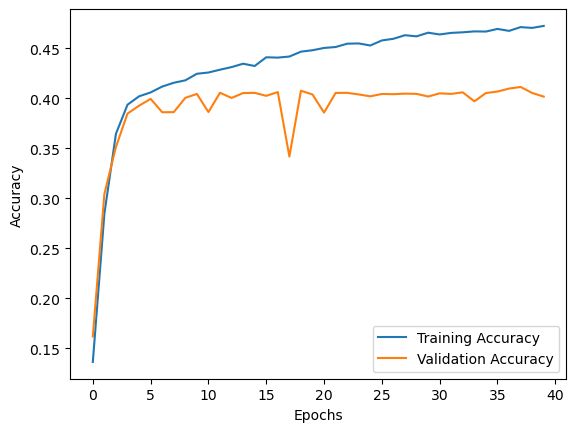

In [ ]:
#plot of accuracy
plt.plot(train_accs, label="Training Accuracy")
plt.plot(val_accs, label="Validation Accuracy")
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()


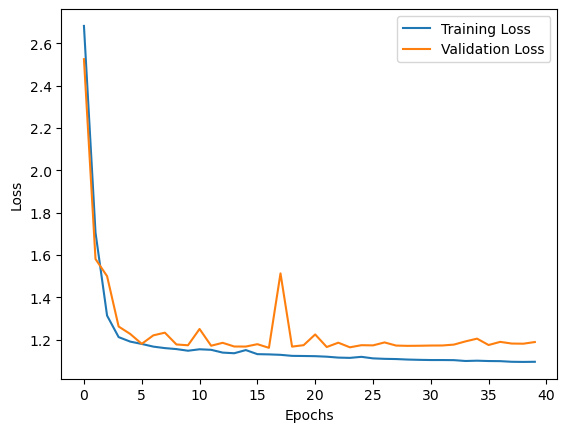

In [ ]:
#plot of loss
plt.plot(train_losses, label="Training Loss")
plt.plot(val_losses, label="Validation Loss")
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

Based on the plots, the model starts to overfit at about 8 epochs.

### Part b.

(Conceptual question) What is the advantage of nn.LSTM over nn.RNN?

**Answer:** The nn.LSTM can capture long-term dependencies in sequential data better than nn.RNN. On the other hand, nn.RNN suffers from vanishing gradients, so it performs less well on long sequences. The nn.LSTM has forget/input/output gates which help it retain important information for long-term periods and forget irrelevant information as information flows through the network. It also has a separate cell state throughout the network that is altered by the gates, allowing information to flow across time steps. Thus, nn.LSTM handles long sequences and long-term dependencies better than a basic nn.RNN because of the controlled memory mechanism.

### Part c.
(Conceptual question) Explain why padding is sometimes necessary when training an RNN.

**Answer:** Padding is sometimes necessary while training an RNN because when it processes sequences of different lengths, padding adds extra 0s to the shorter sequences so that sequences in the same batch are equal in length. We want sequences of the same length so we can take advantage of batching, where we can pack together multiple sequences into fixed-size batches for better computational efficiency and memory usage with equal tensor shapes.

Since we have a limited amount of time for this project, I have decided to designate the questions below as extra credit questions. No help from the teaching staff will be provided for extra credit questions, although clarifications will still be available.

### Part d. (up to 3 points extra credit to cover any lost points on this project. The maximum total number of points remains 100)

Save the model with the highest validation accuracy to evaluate on the test set. Report accuracy on test set. Which answer classes the model most struggles with (bottom 5)?


In [ ]:
#initialize trackers for loss
t_loss = 0.0
t_correct = 0
t_total = 0

#initialize arrays for tracking statistics for each class
num_class=out_size
count_class_correct = [0 for _ in range(num_class)]
count_class_total = [0 for _ in range(num_class)]
class_accs = {}

#get the best epoch model with highest validation accuracy
best_epoch=val_accs.index(max(val_accs))+1
best_model_path = f"model_epoch_{best_epoch}.pth"
model.load_state_dict(torch.load(best_model_path))
torch.save(model.state_dict(), "best_model.pth")

#set model to evaluation mode
model.eval()
with tqdm(test_loader, desc="Testing", unit="batch") as t_bar:
    with torch.no_grad():
        for bch_idx in t_bar:
            #extract images, questions, labels/answers
            im = bch_idx['image']
            qs = bch_idx['question']
            lb = bch_idx['answer']
            lb = lb.view(-1).long()

            #extract model output and calculate correct and total
            out = model(im, qs)

            loss = criterion(out, lb)
            t_loss += loss.item()

            _, pred = torch.max(out, 1)
            t_correct += (pred == lb).sum().item()
            t_total += lb.size(0)

            #update per class statistics
            for i in range(lb.size(0)):
                lab = lb[i].item()
                count_class_total[lab]+=1

                check_correct = (pred[i] == lab).item()
                count_class_correct[lab] += check_correct

#calculate and show test accuracy
t_accuracy = t_correct / t_total
print(f"Test Acc: {t_accuracy:.4f}")

Testing: 100%|██████████| 1032/1032 [09:43<00:00,  1.77batch/s]

Test Acc: 0.4065
Bottom 5 Classes the model most struggles with: 
class = 21, class accuracy = 0.0000
class = 23, class accuracy = 0.0000
class = 24, class accuracy = 0.0000
class = 25, class accuracy = 0.0000
class = 26, class accuracy = 0.0000


**Note:** Note that we see classes with 0 accuracy, as we forgot to account for the labels we removed earlier in get_questions(). However, as per the guidance on Ed, we are assuming we have all the classes and thus not re-doing the model.

In [ ]:
#fill the class accuracy array
for i in range(num_class):
    if count_class_total[i]>0:
        acc = count_class_correct[i]/count_class_total[i]
    class_accs[i] = acc

#sort the class accuracies and extract bottom 5 classes, show
bottom_5_classes = sorted(class_accs, key=class_accs.get)[:5]
print("Bottom 5 Classes the model most struggles with: ")

for i in bottom_5_classes:
    print(f"class = {i}, class accuracy = {class_accs[i]:.4f}")

Bottom 5 Classes the model most struggles with: 
class = 11, class accuracy = 0.0207
class = 8, class accuracy = 0.1733
class = 18, class accuracy = 0.1987
class = 12, class accuracy = 0.2053
class = 7, class accuracy = 0.2113


### Part e. (Extra credit–not an easy task)

Explain the concept of Transformer. Incorporate the Transformer architecture into the model to enhance its performance.  

**Conceptual Explanation:** A Transformer is a type of neural network model that tracks is able to learn context. It does this by considering the relationships between different bits of information in sequential data, such as a sentence of words.

Transformer models do not necessarily process input text in sequence like RNNs do, and thus encode the position of elements. This allows them to be more parallelizable, and helps it with "long-distance" relationships. Additionally, transformers apply the concept of self-attention, where each word can affect the representation of potentially every other word. This makes transformers better at understanding the "meaning" behind text.

Unfortunately, we ran into a server error and could not finish training for our transformer.

In [ ]:
# Acknowledgement: We consulted the PyTorch documentation found here:
# https://pytorch.org/tutorials/beginner/transformer_tutorial.html
# for this section


class TransformerQuestionEmbedModel(nn.Module):
    def __init__(self, in_size, embed=32, hidden=128, n_layers=4, n_heads=8, dropout = 0.2):
        super(TransformerQuestionEmbedModel, self).__init__()
        self.wembedding = nn.Embedding(in_size+1, embed)

        # create Transformer layers
        encoder_layers = nn.TransformerEncoderLayer(
            d_model=embed, nhead=n_heads, dim_feedforward=hidden, dropout=dropout, batch_first=True)
        self.transformer_encoder = nn.TransformerEncoder(encoder_layers, num_layers=n_layers)
        self.positional_encoding = PositionalEncoding(embed, dropout)
        self.layer_norm = LayerNorm(embed)
        self.init_weights()

    def init_weights(self):
        initrange = 0.1
        self.wembedding.weight.data.uniform_(-initrange, initrange)

    def forward(self, question):
        wembed = self.wembedding(question)
        wembed = self.positional_encoding(wembed)
        seq_len = wembed.size(1)
        mask = nn.Transformer.generate_square_subsequent_mask(seq_len)
        mask = mask.to(wembed.device)
        qst_emb = self.transformer_encoder(wembed, mask)
        qst_emb = self.layer_norm(qst_emb)
        return qst_emb[:, -1, :]

# positional encodings, where maxlen 5000 is a safe estimate as no questions
# go over 1000 words
class PositionalEncoding(nn.Module):
    def __init__(self, d_model: int, dropout = 0.2, max_len = 1000):
        super().__init__()
        self.dropout = nn.Dropout(p=dropout)

        # 10,000 used as arbitrary scalar
        position = torch.arange(max_len).unsqueeze(1)
        # vectorized math that gets encodings
        # creates vector of even indices up to the model dimension
        div_term = torch.exp(torch.arange(0, d_model, 2) * (-math.log(10000.0) / d_model))

        # create positional vector, where we use sine for the even
        # and cosine for the odd frequencies
        pe = torch.zeros(max_len, 1, d_model)
        # note we use vectorized math here for efficiency
        pe[:, 0, 0::2] = torch.sin(position * div_term)
        pe[:, 0, 1::2] = torch.cos(position * div_term)
        self.register_buffer('pe', pe)

    def forward(self, x):
        x = x + self.pe[:x.size(0)]
        return self.dropout(x)


class CNNTransformerModel(nn.Module):
    def __init__(self, in_size, out_size, embed=32, hidden=128, n_layers=4, n_heads=8, dropout = 0.2):
        super(CNNTransformerModel, self).__init__()

        # same as initial CNNLSTM, but now using Transformer for question embed
        self.cnn = ConvInputModel()
        self.transformer = TransformerQuestionEmbedModel(in_size, embed, hidden, n_layers, n_heads)
        transformer_out_size = 32
        self.fc1 = nn.Linear(24 * (8 ** 2) + transformer_out_size, 256)
        self.fc2 = nn.Linear(256, out_size)
        self.dropout = nn.Dropout(p=dropout)

    def forward(self, img, qst):
        img_emb = self.cnn(img)
        _, k, d, _ = img_emb.size()
        img_emb = img_emb.view(-1, k*(d**2))
        qst_emb = self.transformer(qst)
        x = torch.cat((img_emb, qst_emb), 1)
        x = F.relu(self.fc1(x))
        x = self.dropout(x)
        x = self.fc2(x)
        return x



In [ ]:
#device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

#set random seed
random_seed = 2023
torch.manual_seed(random_seed)

# initialize model, optimizer, loss function, and other inputs
vocab_size = len(dictionaries[0])
out_size = 29
epochs = 40
model_t = CNNTransformerModel(vocab_size, out_size)
optimizer = optim.Adam(model_t.parameters(), weight_decay=1e-4)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', patience=3, factor=0.5)
criterion = nn.CrossEntropyLoss()

# initialize arrays for tracking losses/accuracies
train_losses = []
val_losses = []
train_accs = []
val_accs = []

#main training/validation loop over set epochs
for epoch in range(epochs):

    #set model to train mode
    model_t.train()
    #initialize variables for each epoch
    train_loss = 0.0
    correct = 0
    total = 0

    val_loss = 0.0
    val_correct = 0
    val_total = 0

    #training loop
    with tqdm(train_loader, desc=f"Epoch {epoch+1}/{epochs}", unit="batch") as bar:
        for bch_idx in bar:
            #load in images, questions, labels
            im = bch_idx['image']
            qs = bch_idx['question']
            lb = bch_idx['answer']
            lb = lb.view(-1).long()

            #extract model output and calculate accuracy/loss
            optimizer.zero_grad()
            out = model_t(im, qs)

            loss = criterion(out, lb)
            loss.backward()
            torch.nn.utils.clip_grad_norm_(model_t.parameters(), max_norm=1.0)
            optimizer.step()

            _, pred = torch.max(out, 1)
            correct += (pred == lb).sum().item()
            total += lb.size(0)

            train_loss += loss.item()

            bar.set_postfix(loss=train_loss /len(bar))

        #append accuracies and losses to relevant arrays
        train_accs.append(correct / total)
        train_losses.append(train_loss / len(train_loader))

    #save models for each epoch
    torch.save(model_t.state_dict(), f"model_transformer_epoch_{epoch+1}.pth")

    #set model to evaluation mode
    model_t.eval()
    #validation loop
    with tqdm(val_loader, desc="validation", unit="batch") as v_bar:
        with torch.no_grad():
            for bch_idx in v_bar:
                #extract images, questions, and answers/labels
                im = bch_idx['image']
                qs = bch_idx['question']
                lb = bch_idx['answer']
                lb = lb.view(-1).long()

                #extract output and calculate accuracies/losses
                out = model_t(im, qs)

                loss = criterion(out, lb)
                val_loss += loss.item()

                _, pred = torch.max(out, 1)
                val_correct += (pred == lb).sum().item()
                val_total += lb.size(0)

    #append accuracies/losses to relevant arrays
    val_accs.append(val_correct / val_total)
    val_losses.append(val_loss / len(val_loader))
    scheduler.step(val_loss)

    #print for each epoch train/validation accuracies/losses
    print(f"Epoch {epoch+1}/{epochs}. Train Acc: {train_accs[-1]:.4f}. Val Acc: {val_accs[-1]:.4f}. Train Loss: {train_losses[-1]:.4f}. Val Loss: {val_losses[-1]:.4f}")

validation: 100%|██████████| 1375/1375 [01:37<00:00, 14.05batch/s]


Epoch 1/40. Train Acc: 0.1580. Val Acc: 0.1918. Train Loss: 2.5263. Val Loss: 2.3418


validation: 100%|██████████| 1375/1375 [01:01<00:00, 22.30batch/s]


Epoch 2/40. Train Acc: 0.2453. Val Acc: 0.2654. Train Loss: 2.0683. Val Loss: 1.7496


validation: 100%|██████████| 1375/1375 [01:00<00:00, 22.74batch/s]


Epoch 3/40. Train Acc: 0.3053. Val Acc: 0.3417. Train Loss: 1.6514. Val Loss: 1.4555


validation: 100%|██████████| 1375/1375 [01:01<00:00, 22.37batch/s]


Epoch 4/40. Train Acc: 0.3461. Val Acc: 0.3668. Train Loss: 1.4311. Val Loss: 1.3110


validation: 100%|██████████| 1375/1375 [01:01<00:00, 22.23batch/s]


Epoch 5/40. Train Acc: 0.3666. Val Acc: 0.3056. Train Loss: 1.3356. Val Loss: 1.4838


validation: 100%|██████████| 1375/1375 [01:01<00:00, 22.42batch/s]


Epoch 6/40. Train Acc: 0.3742. Val Acc: 0.3873. Train Loss: 1.3013. Val Loss: 1.2537


validation: 100%|██████████| 1375/1375 [01:01<00:00, 22.26batch/s]


Epoch 7/40. Train Acc: 0.3819. Val Acc: 0.3834. Train Loss: 1.2688. Val Loss: 1.2272


validation: 100%|██████████| 1375/1375 [01:01<00:00, 22.43batch/s]


Epoch 8/40. Train Acc: 0.3843. Val Acc: 0.3799. Train Loss: 1.2565. Val Loss: 1.2669


validation: 100%|██████████| 1375/1375 [01:01<00:00, 22.36batch/s]


Epoch 9/40. Train Acc: 0.3860. Val Acc: 0.3935. Train Loss: 1.2446. Val Loss: 1.2066


validation: 100%|██████████| 1375/1375 [01:00<00:00, 22.55batch/s]


Epoch 10/40. Train Acc: 0.3892. Val Acc: 0.3924. Train Loss: 1.2359. Val Loss: 1.2191


validation: 100%|██████████| 1375/1375 [01:00<00:00, 22.55batch/s]


Epoch 11/40. Train Acc: 0.3927. Val Acc: 0.3876. Train Loss: 1.2301. Val Loss: 1.2140


validation: 100%|██████████| 1375/1375 [01:01<00:00, 22.46batch/s]


Epoch 12/40. Train Acc: 0.3944. Val Acc: 0.3891. Train Loss: 1.2268. Val Loss: 1.2106


validation: 100%|██████████| 1375/1375 [01:00<00:00, 22.83batch/s]


Epoch 13/40. Train Acc: 0.3957. Val Acc: 0.3953. Train Loss: 1.2224. Val Loss: 1.1991


validation: 100%|██████████| 1375/1375 [01:01<00:00, 22.47batch/s]


Epoch 14/40. Train Acc: 0.3962. Val Acc: 0.3925. Train Loss: 1.2222. Val Loss: 1.2017


validation: 100%|██████████| 1375/1375 [01:00<00:00, 22.55batch/s]


Epoch 15/40. Train Acc: 0.3955. Val Acc: 0.3983. Train Loss: 1.2209. Val Loss: 1.2003


validation: 100%|██████████| 1375/1375 [01:00<00:00, 22.56batch/s]


Epoch 16/40. Train Acc: 0.3983. Val Acc: 0.3971. Train Loss: 1.2173. Val Loss: 1.1971


validation: 100%|██████████| 1375/1375 [01:01<00:00, 22.54batch/s]


Epoch 17/40. Train Acc: 0.3974. Val Acc: 0.3880. Train Loss: 1.2159. Val Loss: 1.2206


validation: 100%|██████████| 1375/1375 [01:00<00:00, 22.56batch/s]


Epoch 18/40. Train Acc: 0.3976. Val Acc: 0.3968. Train Loss: 1.2140. Val Loss: 1.1995


validation: 100%|██████████| 1375/1375 [01:00<00:00, 22.57batch/s]


Epoch 19/40. Train Acc: 0.3948. Val Acc: 0.3973. Train Loss: 1.2128. Val Loss: 1.1898


validation: 100%|██████████| 1375/1375 [01:03<00:00, 21.82batch/s]


Epoch 20/40. Train Acc: 0.3968. Val Acc: 0.3972. Train Loss: 1.2125. Val Loss: 1.2044


validation: 100%|██████████| 1375/1375 [01:02<00:00, 22.15batch/s]


Epoch 21/40. Train Acc: 0.3993. Val Acc: 0.3942. Train Loss: 1.2100. Val Loss: 1.2034


validation: 100%|██████████| 1375/1375 [01:01<00:00, 22.33batch/s]


Epoch 22/40. Train Acc: 0.3988. Val Acc: 0.3950. Train Loss: 1.2075. Val Loss: 1.1993


validation: 100%|██████████| 1375/1375 [01:01<00:00, 22.23batch/s]


Epoch 23/40. Train Acc: 0.4020. Val Acc: 0.3888. Train Loss: 1.2064. Val Loss: 1.2107


validation: 100%|██████████| 1375/1375 [01:01<00:00, 22.53batch/s]


Epoch 24/40. Train Acc: 0.4127. Val Acc: 0.4056. Train Loss: 1.1839. Val Loss: 1.1799


validation: 100%|██████████| 1375/1375 [01:01<00:00, 22.47batch/s]


Epoch 25/40. Train Acc: 0.4166. Val Acc: 0.4057. Train Loss: 1.1773. Val Loss: 1.1844


validation: 100%|██████████| 1375/1375 [01:01<00:00, 22.36batch/s]


Epoch 26/40. Train Acc: 0.4170. Val Acc: 0.3986. Train Loss: 1.1735. Val Loss: 1.1797


validation: 100%|██████████| 1375/1375 [01:02<00:00, 21.94batch/s]


Epoch 27/40. Train Acc: 0.4200. Val Acc: 0.4042. Train Loss: 1.1701. Val Loss: 1.1789


validation: 100%|██████████| 1375/1375 [01:02<00:00, 22.14batch/s]


Epoch 28/40. Train Acc: 0.4225. Val Acc: 0.4045. Train Loss: 1.1708. Val Loss: 1.1800


validation: 100%|██████████| 1375/1375 [01:01<00:00, 22.37batch/s]


Epoch 29/40. Train Acc: 0.4231. Val Acc: 0.3947. Train Loss: 1.1697. Val Loss: 1.2067


validation: 100%|██████████| 1375/1375 [01:01<00:00, 22.44batch/s]


Epoch 30/40. Train Acc: 0.4239. Val Acc: 0.4063. Train Loss: 1.1685. Val Loss: 1.1820


validation: 100%|██████████| 1375/1375 [01:01<00:00, 22.46batch/s]


Epoch 31/40. Train Acc: 0.4276. Val Acc: 0.4058. Train Loss: 1.1663. Val Loss: 1.1770


validation: 100%|██████████| 1375/1375 [01:01<00:00, 22.33batch/s]


Epoch 32/40. Train Acc: 0.4290. Val Acc: 0.3982. Train Loss: 1.1651. Val Loss: 1.1862


validation: 100%|██████████| 1375/1375 [01:01<00:00, 22.34batch/s]


Epoch 33/40. Train Acc: 0.4292. Val Acc: 0.4036. Train Loss: 1.1637. Val Loss: 1.1854


validation: 100%|██████████| 1375/1375 [01:01<00:00, 22.25batch/s]


Epoch 34/40. Train Acc: 0.4322. Val Acc: 0.4012. Train Loss: 1.1642. Val Loss: 1.1841


validation: 100%|██████████| 1375/1375 [01:01<00:00, 22.49batch/s]


Epoch 35/40. Train Acc: 0.4323. Val Acc: 0.3973. Train Loss: 1.1624. Val Loss: 1.1810


validation: 100%|██████████| 1375/1375 [01:01<00:00, 22.51batch/s]


Epoch 36/40. Train Acc: 0.4470. Val Acc: 0.4055. Train Loss: 1.1402. Val Loss: 1.1749


validation: 100%|██████████| 1375/1375 [01:01<00:00, 22.44batch/s]


Epoch 37/40. Train Acc: 0.4497. Val Acc: 0.4087. Train Loss: 1.1360. Val Loss: 1.1753


validation: 100%|██████████| 1375/1375 [01:01<00:00, 22.27batch/s]


Epoch 38/40. Train Acc: 0.4547. Val Acc: 0.4072. Train Loss: 1.1313. Val Loss: 1.1733


validation: 100%|██████████| 1375/1375 [01:01<00:00, 22.26batch/s]


Epoch 39/40. Train Acc: 0.4555. Val Acc: 0.4045. Train Loss: 1.1278. Val Loss: 1.1766


validation: 100%|██████████| 1375/1375 [01:01<00:00, 22.43batch/s]

Epoch 40/40. Train Acc: 0.4591. Val Acc: 0.4057. Train Loss: 1.1256. Val Loss: 1.1767


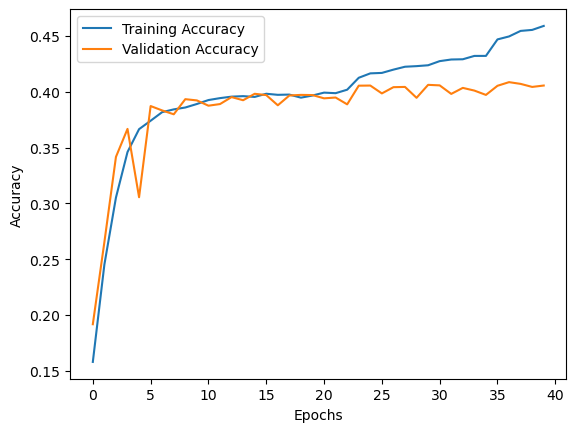

In [ ]:
plt.plot(train_accs, label="Training Accuracy")
plt.plot(val_accs, label="Validation Accuracy")
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

In [ ]:
#initialize trackers for loss
t_loss = 0.0
t_correct = 0
t_total = 0

#get the best epoch model with highest validation accuracy
best_epoch_t=val_accs.index(max(val_accs))+1
best_model_path_t = f"model_transformer_epoch_{best_epoch_t}.pth"
model_t.load_state_dict(torch.load(best_model_path_t))
torch.save(model_t.state_dict(), "best_model.pth")

#set model to evaluation mode
model_t.eval()
with tqdm(test_loader, desc="Testing", unit="batch") as t_bar:
    with torch.no_grad():
        for bch_idx in t_bar:
            #extract images, questions, labels/answers
            im = bch_idx['image'].to(device)
            qs = bch_idx['question'].to(device)
            lb = bch_idx['answer'].to(device)
            lb = lb.view(-1).long()

            #extract model output and calculate correct and total
            out = model_t(im, qs)

            loss = criterion(out, lb)
            t_loss += loss.item()

            _, pred = torch.max(out, 1)
            t_correct += (pred == lb).sum().item()
            t_total += lb.size(0)

#calculate and show test accuracy
t_accuracy = t_correct / t_total
print(f"Test Acc: {t_accuracy:.4f}")

Testing: 100%|██████████| 1032/1032 [18:35<00:00,  1.08s/batch]Test Acc: 0.4738
